# Null-text inversion + Editing with Prompt-to-Prompt

In [1]:
from typing import Optional, Union, Tuple, List, Callable, Dict
from tqdm.notebook import tqdm
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
import torch.nn.functional as nnf
import torch.nn as nn
import numpy as np
import abc
import ptp_utils
import seq_aligner
import shutil
from torch.optim.adam import Adam
from PIL import Image

In [2]:
import matplotlib.pyplot as plt

def plot_side_by_side(img_array, names=[]):
# Create a figure and display the image
    num_imgs = len(img_array)
    plt.subplots(1,num_imgs, figsize=(15,5))

    for i in range(1,num_imgs+1):
        plt.subplot(1,num_imgs,i)
        #plt.imshow(img_array[i-1].cpu().squeeze(0).permute(1,2,0).detach().numpy())
        plt.imshow(img_array[i-1])
        if len(names)>0:
            plt.title(str(names[i-1]))
        plt.axis('off')
    # Show the figure
    plt.show()
def kldiv(s_map, gt):
    gt = torch.Tensor(gt).mean(-1).unsqueeze(-1)
    s_map = torch.Tensor(s_map).mean(-1).unsqueeze(-1)
    print(s_map.size())
    print(gt.size())    
    batch_size = s_map.size(0)
    w = s_map.size(1)
    h = s_map.size(2)

    sum_s_map = torch.sum(s_map.view(batch_size, -1), 1)
    expand_s_map = sum_s_map.view(batch_size, 1, 1).expand(batch_size, w, h)
    
    assert expand_s_map.size() == s_map.size()

    sum_gt = torch.sum(gt.view(batch_size, -1), 1)
    expand_gt = sum_gt.view(batch_size, 1, 1).expand(batch_size, w, h)
#     print(expand_gt.size())
#     print(gt.size())
    assert expand_gt.size() == gt.size()

    s_map = s_map/(expand_s_map*1.0)
    gt = gt / (expand_gt*1.0)

    s_map = s_map.view(batch_size, -1)
    gt = gt.view(batch_size, -1)

    eps = 2.2204e-16
    result = gt * torch.log(eps + gt/(s_map + eps))
    # print(torch.log(eps + gt/(s_map + eps))   )
    res = torch.mean(torch.sum(result, 1))
    print(res)
    return res

def cc(s_map, gt):
 #   print("smap_loss", s_map.size())
 #   print("gt_loss", gt.size())
    gt = torch.Tensor(gt).mean(-1).unsqueeze(-1)
    s_map = torch.Tensor(s_map).mean(-1).unsqueeze(-1)
    batch_size = s_map.size(0)
    w = s_map.size(1)
    h = s_map.size(2)

    mean_s_map = torch.mean(s_map.view(batch_size, -1), 1).view(batch_size, 1, 1).expand(batch_size, w, h)
    std_s_map = torch.std(s_map.view(batch_size, -1), 1).view(batch_size, 1, 1).expand(batch_size, w, h)

    mean_gt = torch.mean(gt.view(batch_size, -1), 1).view(batch_size, 1, 1).expand(batch_size, w, h)
    std_gt = torch.std(gt.view(batch_size, -1), 1).view(batch_size, 1, 1).expand(batch_size, w, h)

    s_map = (s_map - mean_s_map) / std_s_map
    gt = (gt - mean_gt) / std_gt

    ab = torch.sum((s_map * gt).view(batch_size, -1), 1)
    aa = torch.sum((s_map * s_map).view(batch_size, -1), 1)
    bb = torch.sum((gt * gt).view(batch_size, -1), 1)

    return torch.mean(ab / (torch.sqrt(aa*bb)))    

In [3]:
#### LOAD COCO CAPTIONS
import json
caption_file = "/sinergia/bahar/augsal/filename_and_captions.json"
with open(caption_file, "rt") as f:
    captions = json.load(f)
lines = captions["filenameandcaptions"]
caps = {x["file_name"]: x["text"][0].strip("\n") for x in lines}
    
#caps

In [4]:
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
MY_TOKEN = ''
LOW_RESOURCE = False 
NUM_DDIM_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
ldm_stable = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", use_auth_token=MY_TOKEN, scheduler=scheduler).to(device)
try:
    ldm_stable.disable_xformers_memory_efficient_attention()
except AttributeError:
    print("Attribute disable_xformers_memory_efficient_attention() is missing")
tokenizer = ldm_stable.tokenizer

Fetching 20 files:   0%|          | 0/20 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


In [5]:
print(ldm_stable.unet.time_embedding)

TimestepEmbedding(
  (linear_1): Linear(in_features=320, out_features=1280, bias=True)
  (act): SiLU()
  (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
)


In [6]:
print(ldm_stable.unet.time_proj(torch.Tensor([5])).cuda().shape)

torch.Size([1, 320])


In [7]:
print(ldm_stable.unet.time_embedding(ldm_stable.unet.time_proj(torch.Tensor([10])).cuda()).shape)

torch.Size([1, 1280])


## Prompt-to-Prompt code

In [8]:

class LocalBlend:
    
    def get_mask(self, maps, alpha, use_pool):
        k = 1
        maps = (maps * alpha).sum(-1).mean(1)
        if use_pool:
            maps = nnf.max_pool2d(maps, (k * 2 + 1, k * 2 +1), (1, 1), padding=(k, k))
        mask = nnf.interpolate(maps, size=(x_t.shape[2:]))
        mask = mask / mask.max(2, keepdims=True)[0].max(3, keepdims=True)[0]
        mask = mask.gt(self.th[1-int(use_pool)])
        mask = mask[:1] + mask
        return mask
    
    def __call__(self, x_t, attention_store):
        self.counter += 1
        if self.counter > self.start_blend:
           
            maps = attention_store["down_cross"][2:4] + attention_store["up_cross"][:3]
            maps = [item.reshape(self.alpha_layers.shape[0], -1, 1, 16, 16, MAX_NUM_WORDS) for item in maps]
            maps = torch.cat(maps, dim=1)
            mask = self.get_mask(maps, self.alpha_layers, True)
            if self.substruct_layers is not None:
                maps_sub = ~self.get_mask(maps, self.substruct_layers, False)
                mask = mask * maps_sub
            mask = mask.float()
            x_t = x_t[:1] + mask * (x_t - x_t[:1])
        return x_t
       
    def __init__(self, prompts: List[str], words: [List[List[str]]], substruct_words=None, start_blend=0.2, th=(.3, .3)):
        alpha_layers = torch.zeros(len(prompts),  1, 1, 1, 1, MAX_NUM_WORDS)
        for i, (prompt, words_) in enumerate(zip(prompts, words)):
            if type(words_) is str:
                words_ = [words_]
            for word in words_:
                ind = ptp_utils.get_word_inds(prompt, word, tokenizer)
                alpha_layers[i, :, :, :, :, ind] = 1
        
        if substruct_words is not None:
            substruct_layers = torch.zeros(len(prompts),  1, 1, 1, 1, MAX_NUM_WORDS)
            for i, (prompt, words_) in enumerate(zip(prompts, substruct_words)):
                if type(words_) is str:
                    words_ = [words_]
                for word in words_:
                    ind = ptp_utils.get_word_inds(prompt, word, tokenizer)
                    substruct_layers[i, :, :, :, :, ind] = 1
            self.substruct_layers = substruct_layers.to(device)
        else:
            self.substruct_layers = None
        self.alpha_layers = alpha_layers.to(device)
        self.start_blend = int(start_blend * NUM_DDIM_STEPS)
        self.counter = 0 
        self.th=th


        
        
class EmptyControl:
    
    
    def step_callback(self, x_t):
        return x_t
    
    def between_steps(self):
        return
    
    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        return attn

    
class AttentionControl(abc.ABC):
    
    def step_callback(self, x_t):
        return x_t
    
    def between_steps(self):
        return
    
    @property
    def num_uncond_att_layers(self):
        return self.num_att_layers if LOW_RESOURCE else 0
    
    @abc.abstractmethod
    def forward (self, attn, is_cross: bool, place_in_unet: str):
        raise NotImplementedError

    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        if self.cur_att_layer >= self.num_uncond_att_layers:
            if LOW_RESOURCE:
                attn = self.forward(attn, is_cross, place_in_unet)
            else:
                h = attn.shape[0]
                attn[h // 2:] = self.forward(attn[h // 2:], is_cross, place_in_unet)
        self.cur_att_layer += 1
        if self.cur_att_layer == self.num_att_layers + self.num_uncond_att_layers:
            self.cur_att_layer = 0
            self.cur_step += 1
            self.between_steps()
        return attn
    
    def reset(self):
        self.cur_step = 0
        self.cur_att_layer = 0

    def __init__(self):
        self.cur_step = 0
        self.num_att_layers = -1
        self.cur_att_layer = 0

class SpatialReplace(EmptyControl):
    
    def step_callback(self, x_t):
        if self.cur_step < self.stop_inject:
            b = x_t.shape[0]
            x_t = x_t[:1].expand(b, *x_t.shape[1:])
        return x_t

    def __init__(self, stop_inject: float):
        super(SpatialReplace, self).__init__()
        self.stop_inject = int((1 - stop_inject) * NUM_DDIM_STEPS)
        

class AttentionStore(AttentionControl):

    @staticmethod
    def get_empty_store():
        return {"down_cross": [], "mid_cross": [], "up_cross": [],
                "down_self": [],  "mid_self": [],  "up_self": []}

    def forward(self, attn, is_cross: bool, place_in_unet: str):
        key = f"{place_in_unet}_{'cross' if is_cross else 'self'}"
        if attn.shape[1] <= 32 ** 2:  # avoid memory overhead
            self.step_store[key].append(attn)
        return attn

    def between_steps(self):
        if len(self.attention_store) == 0:
            self.attention_store = self.step_store
        else:
            for key in self.attention_store:
                for i in range(len(self.attention_store[key])):
                    self.attention_store[key][i] += self.step_store[key][i]
        self.step_store = self.get_empty_store()

    def get_average_attention(self):
        average_attention = {key: [item / self.cur_step for item in self.attention_store[key]] for key in self.attention_store}
        return average_attention


    def reset(self):
        super(AttentionStore, self).reset()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

    def __init__(self):
        super(AttentionStore, self).__init__()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

        
class AttentionControlEdit(AttentionStore, abc.ABC):
    
    def step_callback(self, x_t):
        if self.local_blend is not None:
            x_t = self.local_blend(x_t, self.attention_store)
        return x_t
        
    def replace_self_attention(self, attn_base, att_replace, place_in_unet):
        if att_replace.shape[2] <= 32 ** 2:
            attn_base = attn_base.unsqueeze(0).expand(att_replace.shape[0], *attn_base.shape)
            return attn_base
        else:
            return att_replace
    
    @abc.abstractmethod
    def replace_cross_attention(self, attn_base, att_replace):
        raise NotImplementedError
    
    def forward(self, attn, is_cross: bool, place_in_unet: str):
        super(AttentionControlEdit, self).forward(attn, is_cross, place_in_unet)
        if is_cross or (self.num_self_replace[0] <= self.cur_step < self.num_self_replace[1]):
            h = attn.shape[0] // (self.batch_size)
            attn = attn.reshape(self.batch_size, h, *attn.shape[1:])
            attn_base, attn_repalce = attn[0], attn[1:]
            if is_cross:
                alpha_words = self.cross_replace_alpha[self.cur_step]
                attn_repalce_new = self.replace_cross_attention(attn_base, attn_repalce) * alpha_words + (1 - alpha_words) * attn_repalce
                attn[1:] = attn_repalce_new
            else:
                attn[1:] = self.replace_self_attention(attn_base, attn_repalce, place_in_unet)
            attn = attn.reshape(self.batch_size * h, *attn.shape[2:])
        return attn
    
    def __init__(self, prompts, num_steps: int,
                 cross_replace_steps: Union[float, Tuple[float, float], Dict[str, Tuple[float, float]]],
                 self_replace_steps: Union[float, Tuple[float, float]],
                 local_blend: Optional[LocalBlend]):
        super(AttentionControlEdit, self).__init__()
        self.batch_size = len(prompts)
        self.cross_replace_alpha = ptp_utils.get_time_words_attention_alpha(prompts, num_steps, cross_replace_steps, tokenizer).to(device)
        if type(self_replace_steps) is float:
            self_replace_steps = 0, self_replace_steps
        self.num_self_replace = int(num_steps * self_replace_steps[0]), int(num_steps * self_replace_steps[1])
        self.local_blend = local_blend

class AttentionReplace(AttentionControlEdit):

    def replace_cross_attention(self, attn_base, att_replace):
        return torch.einsum('hpw,bwn->bhpn', attn_base, self.mapper)
      
    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float,
                 local_blend: Optional[LocalBlend] = None):
        super(AttentionReplace, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend)
        self.mapper = seq_aligner.get_replacement_mapper(prompts, tokenizer).to(device)
        

class AttentionRefine(AttentionControlEdit):

    def replace_cross_attention(self, attn_base, att_replace):
        attn_base_replace = attn_base[:, :, self.mapper].permute(2, 0, 1, 3)
        attn_replace = attn_base_replace * self.alphas + att_replace * (1 - self.alphas)
        # attn_replace = attn_replace / attn_replace.sum(-1, keepdims=True)
        return attn_replace

    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float,
                 local_blend: Optional[LocalBlend] = None):
        super(AttentionRefine, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend)
        self.mapper, alphas = seq_aligner.get_refinement_mapper(prompts, tokenizer)
        self.mapper, alphas = self.mapper.to(device), alphas.to(device)
        self.alphas = alphas.reshape(alphas.shape[0], 1, 1, alphas.shape[1])


class AttentionReweight(AttentionControlEdit):

    def replace_cross_attention(self, attn_base, att_replace):
        if self.prev_controller is not None:
            attn_base = self.prev_controller.replace_cross_attention(attn_base, att_replace)
        attn_replace = attn_base[None, :, :, :] * self.equalizer[:, None, None, :]
        # attn_replace = attn_replace / attn_replace.sum(-1, keepdims=True)
        return attn_replace

    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float, equalizer,
                local_blend: Optional[LocalBlend] = None, controller: Optional[AttentionControlEdit] = None):
        super(AttentionReweight, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend)
        self.equalizer = equalizer.to(device)
        self.prev_controller = controller


def get_equalizer(text: str, word_select: Union[int, Tuple[int, ...]], values: Union[List[float],
                  Tuple[float, ...]]):
    if type(word_select) is int or type(word_select) is str:
        word_select = (word_select,)
    equalizer = torch.ones(1, 77)
    
    for word, val in zip(word_select, values):
        inds = ptp_utils.get_word_inds(text, word, tokenizer)
        equalizer[:, inds] = val
    return equalizer

def aggregate_attention(attention_store: AttentionStore, res: int, from_where: List[str], is_cross: bool, select: int):
    out = []
    attention_maps = attention_store.get_average_attention()
    num_pixels = res ** 2
    for location in from_where:
        for item in attention_maps[f"{location}_{'cross' if is_cross else 'self'}"]:
            if item.shape[1] == num_pixels:
                cross_maps = item.reshape(len(prompts), -1, res, res, item.shape[-1])[select]
                out.append(cross_maps)
    out = torch.cat(out, dim=0)
    out = out.sum(0) / out.shape[0]
    return out.cpu()


def make_controller(prompts: List[str], is_replace_controller: bool, cross_replace_steps: Dict[str, float], self_replace_steps: float, blend_words=None, equilizer_params=None) -> AttentionControlEdit:
    if blend_words is None:
        lb = None
    else:
        lb = LocalBlend(prompts, blend_word)
    if is_replace_controller:
        controller = AttentionReplace(prompts, NUM_DDIM_STEPS, cross_replace_steps=cross_replace_steps, self_replace_steps=self_replace_steps, local_blend=lb)
    else:
        controller = AttentionRefine(prompts, NUM_DDIM_STEPS, cross_replace_steps=cross_replace_steps, self_replace_steps=self_replace_steps, local_blend=lb)
    if equilizer_params is not None:
        eq = get_equalizer(prompts[1], equilizer_params["words"], equilizer_params["values"])
        controller = AttentionReweight(prompts, NUM_DDIM_STEPS, cross_replace_steps=cross_replace_steps,
                                       self_replace_steps=self_replace_steps, equalizer=eq, local_blend=lb, controller=controller)
    return controller


def show_cross_attention(attention_store: AttentionStore, res: int, from_where: List[str], select: int = 0):
    tokens = tokenizer.encode(prompts[select])
    decoder = tokenizer.decode
    attention_maps = aggregate_attention(attention_store, res, from_where, True, select)
    images = []
    for i in range(len(tokens)):
        image = attention_maps[:, :, i]
        image = 255 * image / image.max()
        image = image.unsqueeze(-1).expand(*image.shape, 3)
        image = image.numpy().astype(np.uint8)
        image = np.array(Image.fromarray(image).resize((256, 256)))
        image = ptp_utils.text_under_image(image, decoder(int(tokens[i])))
        images.append(image)
    ptp_utils.view_images(np.stack(images, axis=0))
    return images

def show_self_attention_comp(attention_store: AttentionStore, res: int, from_where: List[str],
                        max_com=10, select: int = 0):
    attention_maps = aggregate_attention(attention_store, res, from_where, False, select).numpy().reshape((res ** 2, res ** 2))
    u, s, vh = np.linalg.svd(attention_maps - np.mean(attention_maps, axis=1, keepdims=True))
    images = []
    for i in range(max_com):
        image = vh[i].reshape(res, res)
        image = image - image.min()
        image = 255 * image / image.max()
        image = np.repeat(np.expand_dims(image, axis=2), 3, axis=2).astype(np.uint8)
        image = Image.fromarray(image).resize((256, 256))
        image = np.array(image)
        images.append(image)
    ptp_utils.view_images(np.concatenate(images, axis=1))

## Null Text Inversion code


In [94]:
def load_512(image_path, left=0, right=0, top=0, bottom=0):
    if type(image_path) is str:
        if "png" in image_path:
            image = np.repeat(np.expand_dims(np.array(Image.open(image_path)),axis=-1), 3, axis=-1)
        else:    
            image = np.array(Image.open(image_path))[:, :, :3]
    else:
        image = image_path
    image = np.array(Image.fromarray(image).resize((512, 512)))
    return image

class NullInversion:
    
    def prev_step(self, model_output: Union[torch.FloatTensor, np.ndarray], timestep: int, sample: Union[torch.FloatTensor, np.ndarray]):
        prev_timestep = timestep - self.scheduler.config.num_train_timesteps // self.scheduler.num_inference_steps
        alpha_prod_t = self.scheduler.alphas_cumprod[timestep]
        alpha_prod_t_prev = self.scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else self.scheduler.final_alpha_cumprod
        beta_prod_t = 1 - alpha_prod_t
        pred_original_sample = (sample - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5
        pred_sample_direction = (1 - alpha_prod_t_prev) ** 0.5 * model_output
        prev_sample = alpha_prod_t_prev ** 0.5 * pred_original_sample + pred_sample_direction
        return prev_sample
    
    def next_step(self, model_output: Union[torch.FloatTensor, np.ndarray], timestep: int, sample: Union[torch.FloatTensor, np.ndarray]):
        timestep, next_timestep = min(timestep - self.scheduler.config.num_train_timesteps // self.scheduler.num_inference_steps, 999), timestep
        alpha_prod_t = self.scheduler.alphas_cumprod[timestep] if timestep >= 0 else self.scheduler.final_alpha_cumprod
        alpha_prod_t_next = self.scheduler.alphas_cumprod[next_timestep]
        beta_prod_t = 1 - alpha_prod_t
        next_original_sample = (sample - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5
        next_sample_direction = (1 - alpha_prod_t_next) ** 0.5 * model_output
        next_sample = alpha_prod_t_next ** 0.5 * next_original_sample + next_sample_direction
        return next_sample
    
    def get_noise_pred_single(self, latents, t, context):
        noise_pred = self.model.unet(latents, t, encoder_hidden_states=context)["sample"]
        return noise_pred

    def get_noise_pred(self, latents, t, is_forward=True, context=None):
        latents_input = torch.cat([latents] * 2)
        if context is None:
            context = self.context
        guidance_scale = 1 if is_forward else GUIDANCE_SCALE
        noise_pred = self.model.unet(latents_input, t, encoder_hidden_states=context)["sample"]
        noise_pred_uncond, noise_prediction_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)
        if is_forward:
            latents = self.next_step(noise_pred, t, latents)
        else:
            latents = self.prev_step(noise_pred, t, latents)
        return latents

    @torch.no_grad()
    def latent2image(self, latents, return_type='np'):
        latents = 1 / 0.18215 * latents.detach()
        image = self.model.vae.decode(latents)['sample']
        if return_type == 'np':
            image = (image / 2 + 0.5).clamp(0, 1)
            image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
            image = (image * 255).astype(np.uint8)
        return image

    @torch.no_grad()
    def image2latent(self, image):
        with torch.no_grad():
            if type(image) is Image:
                image = np.array(image)
            if type(image) is torch.Tensor and image.dim() == 4:
                latents = image
            else:
                image = torch.from_numpy(image).float() / 127.5 - 1
                image = image.permute(2, 0, 1).unsqueeze(0).to(device)
                latents = self.model.vae.encode(image)['latent_dist'].mean
                latents = latents * 0.18215
        return latents

    @torch.no_grad()
    def init_prompt(self, prompt: str):
        uncond_input = self.model.tokenizer(
            [""], padding="max_length", max_length=self.model.tokenizer.model_max_length,
            return_tensors="pt"
        )
        uncond_embeddings = self.model.text_encoder(uncond_input.input_ids.to(self.model.device))[0]
        text_input = self.model.tokenizer(
            [prompt],
            padding="max_length",
            max_length=self.model.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_embeddings = self.model.text_encoder(text_input.input_ids.to(self.model.device))[0]
        self.context = torch.cat([uncond_embeddings, text_embeddings])
        self.prompt = prompt

    @torch.no_grad()
    def ddim_loop(self, latent):
        uncond_embeddings, cond_embeddings = self.context.chunk(2)
        all_latent = [latent]
        latent = latent.clone().detach()
        for i in range(NUM_DDIM_STEPS):
            t = self.model.scheduler.timesteps[len(self.model.scheduler.timesteps) - i - 1]
            noise_pred = self.get_noise_pred_single(latent, t, cond_embeddings)
            latent = self.next_step(noise_pred, t, latent)
            all_latent.append(latent)
        return all_latent

    @property
    def scheduler(self):
        return self.model.scheduler

    @torch.no_grad()
    def ddim_inversion(self, image):
        latent = self.image2latent(image)
        image_rec = self.latent2image(latent)
        ddim_latents = self.ddim_loop(latent)
        return image_rec, ddim_latents

    def null_optimization(self, latents, num_inner_steps, epsilon,pred_sal):
        uncond_embeddings, cond_embeddings = self.context.chunk(2)
        uncond_embeddings_list = []
        latent_cur = latents[-1]
        bar = tqdm(total=num_inner_steps * NUM_DDIM_STEPS)
        pred_sal = pred_sal.mean()
        pred_sal = pred_sal.repeat(1,4,1,1)
        for i in range(NUM_DDIM_STEPS):
            uncond_embeddings = uncond_embeddings.clone().detach()
            uncond_embeddings.requires_grad = True
            optimizer = Adam([uncond_embeddings], lr=1e-2 * (1. - i / 100.))
            latent_prev = latents[len(latents) - i - 2]
            t = self.model.scheduler.timesteps[i]
            with torch.no_grad():
                noise_pred_cond = self.get_noise_pred_single(latent_cur, t, cond_embeddings)
            for j in range(num_inner_steps):
                noise_pred_uncond = self.get_noise_pred_single(latent_cur, t, uncond_embeddings)
                noise_pred = noise_pred_uncond + GUIDANCE_SCALE * (noise_pred_cond - noise_pred_uncond)
                latents_prev_rec = self.prev_step(noise_pred, t, latent_cur)
                latents_prev_rec = pred_sal.detach() * latents_prev_rec
                latent_prev =  pred_sal.detach() * latent_prev
                loss = nnf.mse_loss(latents_prev_rec, latent_prev)
                loss1 = nn.L1Loss()
                lloss = loss1(torch.zeros_like(pred_sal), pred_sal.detach())*10e-4
                loss = loss + lloss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                loss_item = loss.item()
                bar.update()
                if loss_item < epsilon + i * 2e-5:
                    break
            for j in range(j + 1, num_inner_steps):
                bar.update()
            uncond_embeddings_list.append(uncond_embeddings[:1].detach())
            with torch.no_grad():
                context = torch.cat([uncond_embeddings, cond_embeddings])
                latent_cur = self.get_noise_pred(latent_cur, t, False, context)
        bar.close()
        return uncond_embeddings_list
    
    def invert(self,pred_sal, image_path: str, prompt: str, offsets=(0,0,0,0), num_inner_steps=10, early_stop_epsilon=1e-5, verbose=False):
        self.init_prompt(prompt)
        ptp_utils.register_attention_control(self.model, None)
        image_gt = load_512(image_path, *offsets)
        if verbose:
            print("DDIM inversion...")
        image_rec, ddim_latents = self.ddim_inversion(image_gt)
        if verbose:
            print("Null-text optimization...")
        uncond_embeddings = self.null_optimization(ddim_latents, num_inner_steps, early_stop_epsilon,pred_sal)
        return (image_gt, image_rec), ddim_latents[-1], uncond_embeddings
        
    
    def __init__(self, model):
        scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False,
                                  set_alpha_to_one=False)
        self.model = model
        self.tokenizer = self.model.tokenizer
        self.model.scheduler.set_timesteps(NUM_DDIM_STEPS)
        self.prompt = None
        self.context = None

null_inversion = NullInversion(ldm_stable)


## Infernce Code

In [95]:
@torch.no_grad()
def text2image_ldm_stable(
    model,
    prompt:  List[str],
    controller,
    num_inference_steps: int = 50,
    guidance_scale: Optional[float] = 7.5,
    generator: Optional[torch.Generator] = None,
    latent: Optional[torch.FloatTensor] = None,
    uncond_embeddings=None,
    start_time=50,
    return_type='image'
):
    batch_size = len(prompt)
    ptp_utils.register_attention_control(model, controller)
    height = width = 512
    
    text_input = model.tokenizer(
        prompt,
        padding="max_length",
        max_length=model.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    text_embeddings = model.text_encoder(text_input.input_ids.to(model.device))[0]
    max_length = text_input.input_ids.shape[-1]
    if uncond_embeddings is None:
        uncond_input = model.tokenizer(
            [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
        )
        uncond_embeddings_ = model.text_encoder(uncond_input.input_ids.to(model.device))[0]
    else:
        uncond_embeddings_ = None

    latent, latents = ptp_utils.init_latent(latent, model, height, width, generator, batch_size)
    model.scheduler.set_timesteps(num_inference_steps)
    for i, t in enumerate(tqdm(model.scheduler.timesteps[-start_time:])):
        if uncond_embeddings_ is None:
            context = torch.cat([uncond_embeddings[i].expand(*text_embeddings.shape), text_embeddings])
        else:
            context = torch.cat([uncond_embeddings_, text_embeddings])
        latents = ptp_utils.diffusion_step(model, controller, latents, context, t, guidance_scale, low_resource=False)
        
    if return_type == 'image':
        image = ptp_utils.latent2image(model.vae, latents)
    else:
        image = latents
    return image, latent



def run_and_display(prompts, controller, latent=None, run_baseline=False, generator=None, uncond_embeddings=None, verbose=True):
    if run_baseline:
        print("w.o. prompt-to-prompt")
        images, latent = run_and_display(prompts, EmptyControl(), latent=latent, run_baseline=False, generator=generator)
        print("with prompt-to-prompt")
    images, x_t = text2image_ldm_stable(ldm_stable, prompts, controller, latent=latent, num_inference_steps=NUM_DDIM_STEPS, guidance_scale=GUIDANCE_SCALE, generator=generator, uncond_embeddings=uncond_embeddings)
    if verbose:
        ptp_utils.view_images(images)
    return images, x_t

In [96]:
###DO NOT MODIFIY####

image_path = "./example_images/gnochi_mirror.jpeg"
image_root = "/sinergia/bahar/p2p/prompt-to-prompt/salicon_example_train_images/"
image_name = "COCO_train2014_000000006590.jpg"
image_name = "COCO_train2014_000000000605.jpg"

image_path = image_root+image_name
#prompt = "a cat sitting next to a mirror"
prompt = caps[image_name]
print(prompt)
print(image_path)
#pred_sal = 


A cup of coffee on a plate with a spoon.
/sinergia/bahar/p2p/prompt-to-prompt/salicon_example_train_images/COCO_train2014_000000000605.jpg


In [97]:
(image_gt, image_enc), x_t, uncond_embeddings = null_inversion.invert(mult,image_path, prompt, offsets=(0,0,200,0), verbose=True)

print("Modify or remove offsets according to your image!")

DDIM inversion...
Null-text optimization...


  0%|          | 0/500 [00:00<?, ?it/s]

Modify or remove offsets according to your image!


  0%|          | 0/50 [00:00<?, ?it/s]

showing from left to right: the ground truth image, the vq-autoencoder reconstruction, the null-text inverted image


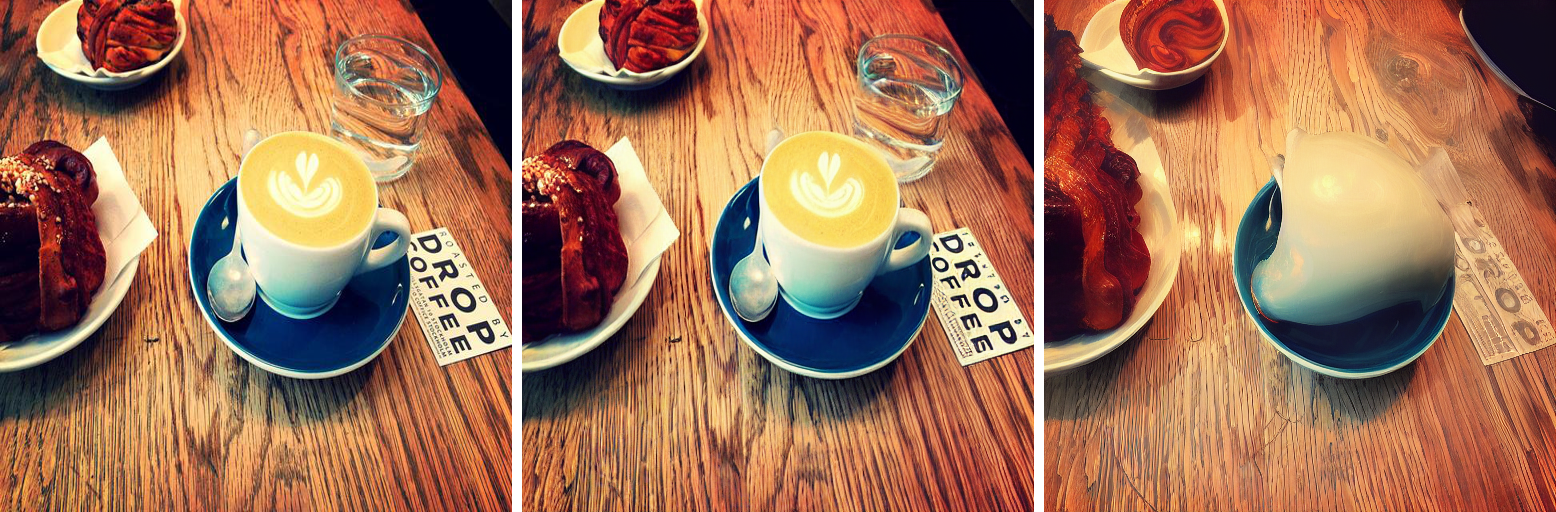

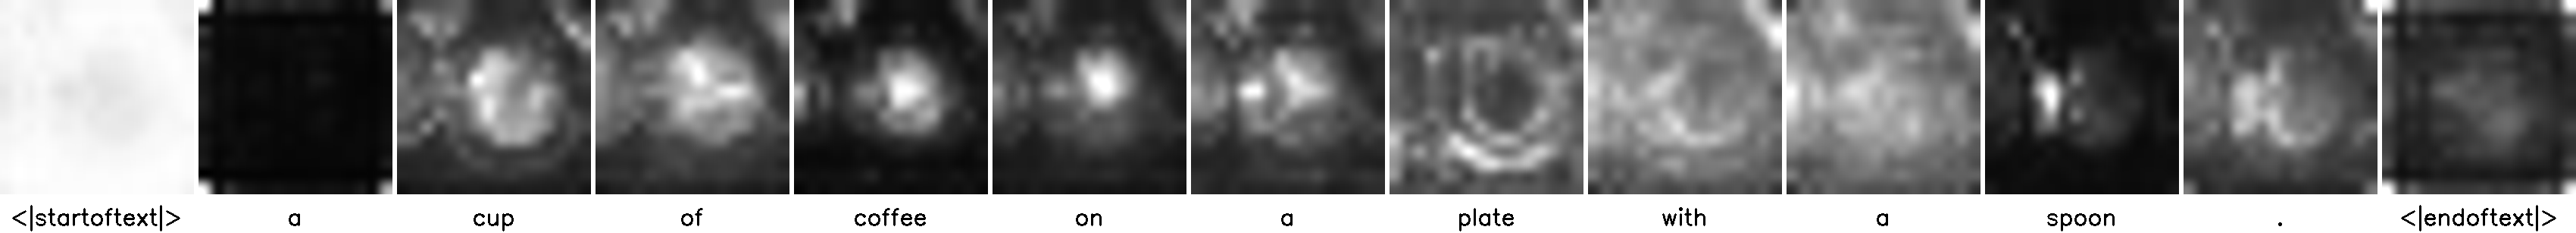

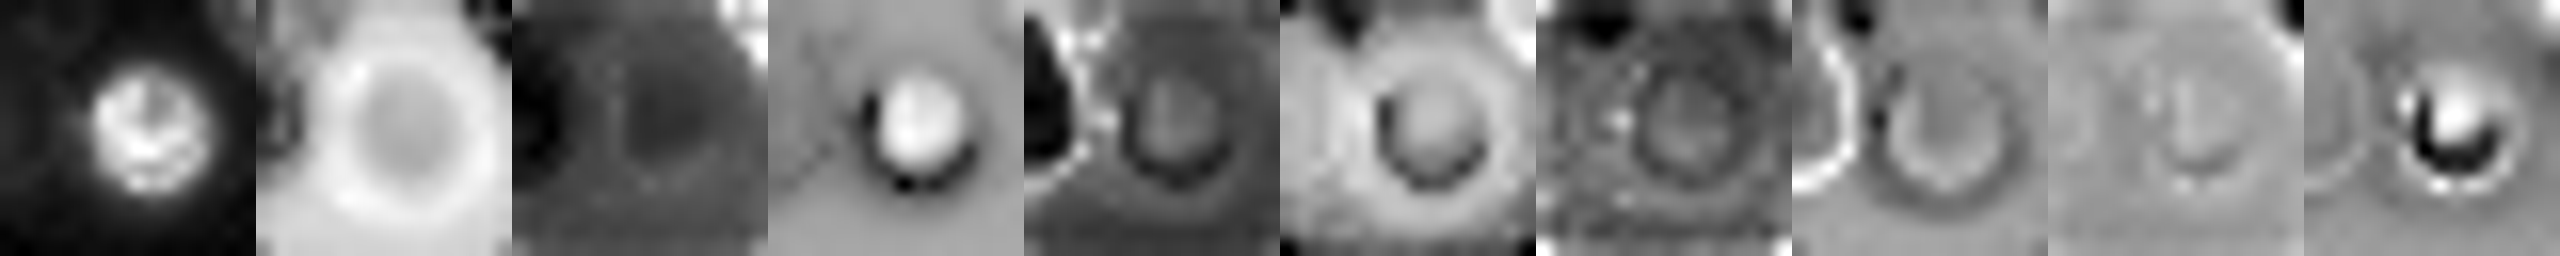

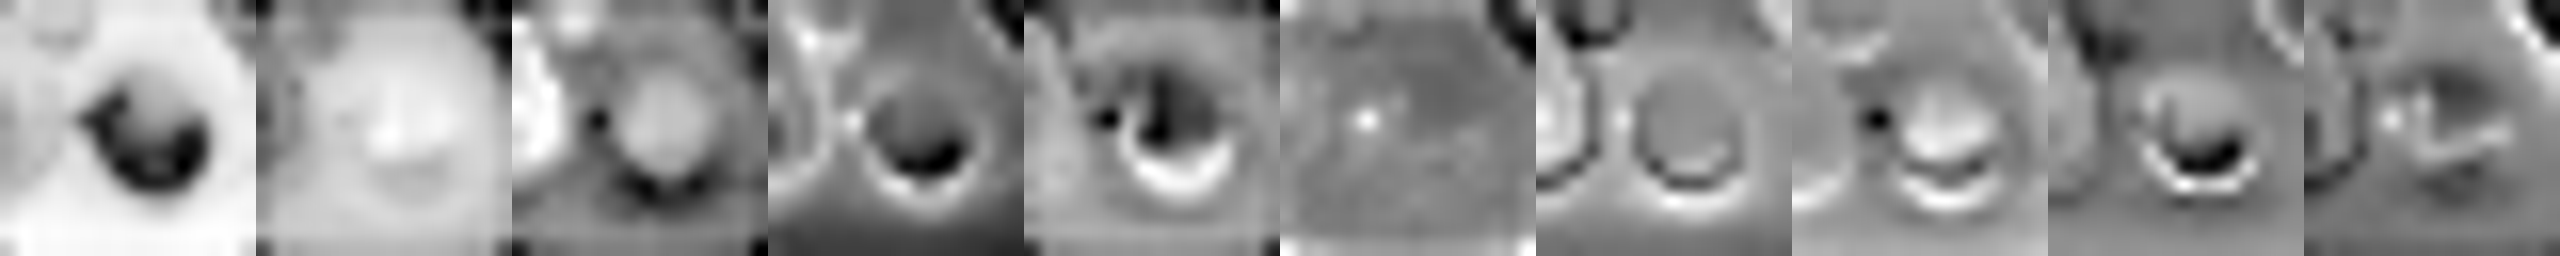

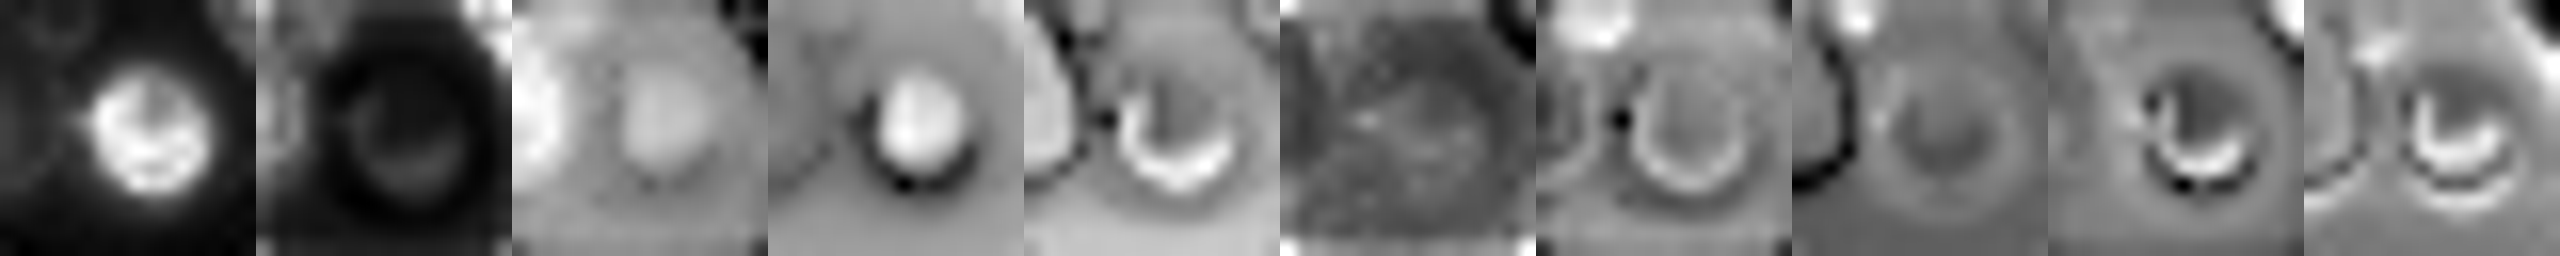

In [98]:
prompts = [prompt]
controller = AttentionStore()
image_inv, x_t = run_and_display(prompts, controller, run_baseline=False, latent=x_t, uncond_embeddings=uncond_embeddings, verbose=False)
print("showing from left to right: the ground truth image, the vq-autoencoder reconstruction, the null-text inverted image")
ptp_utils.view_images([image_gt, image_enc, image_inv[0]])
show_cross_attention(controller, 16, ["up", "down"])
show_self_attention_comp(controller, 16, ["up" ])
# show_self_attention_comp(controller, 16, ["mid" ])
show_self_attention_comp(controller, 16, ["down" ])
show_self_attention_comp(controller, 16, ["up", "down"])


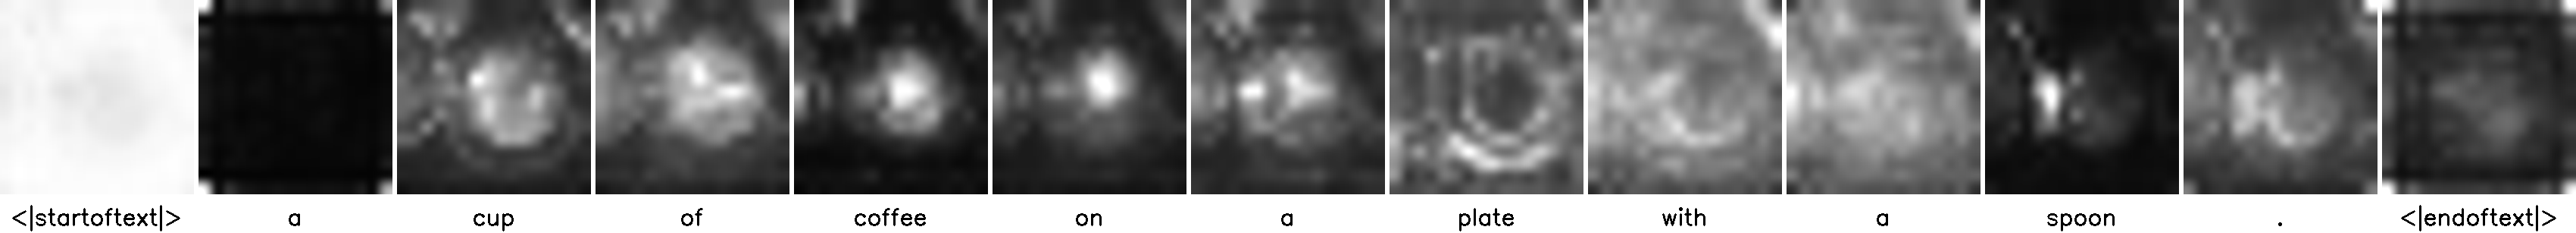

(307, 256, 3)
(256, 307)
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])


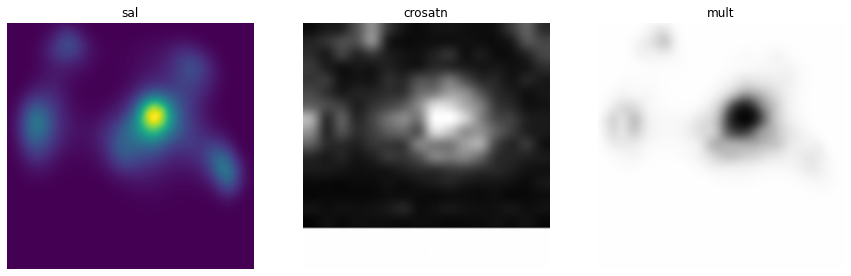

In [89]:
imgs = show_cross_attention(controller, 16, ["up", "down"])
umb = imgs[4]
print(umb.shape)

#umb = np.mean(umb,axis=-1)
umb = Image.fromarray(np.uint8(umb*255))

print(umb.size)
umb2= 1- resize_img(umb, 256, 256).cuda()
print(umb2.shape)

print(pred_sal.shape)
mult = (umb2) * pred_sal.cuda()
print(mult.shape)
mult = 1-mult
mult = mult*mult*mult#*mult*mult#*mult
plot_side_by_side([pred_sal.cpu().permute(1,2,0).detach().numpy(),umb2.cpu().permute(1,2,0).detach().numpy(),mult.cpu().permute(1,2,0).detach().numpy() ], ["sal","crosatn", "mult"])
mult_arr = mult.cpu().permute(1,2,0).detach().numpy()
mult_arr = Image.fromarray(np.uint8(mult_arr*255))

mult= resize_img(mult_arr, 64, 64).cuda()
#############PIR

In [ ]:
#############INVERSION AND SAVE##################
# import os
# source_folder = "/sinergia/bahar/TemporalSaliencyPrediction/data/images/train/"
# target_folder = "/sinergia/bahar/visual-int/salicon-inverted/train/"
# files = os.listdir(source_folder)
# print(len(files), " files found!")    
#     # Loop through the files
# for idx,file in enumerate(files):
#     # Check if the file has a .jpg extension
#     if file.endswith(".jpg"):
#             # Get the full path of the source file
#             image_name = file
#             image_path = source_folder+image_name
#             prompt = caps[image_name]
#             # print(prompt)
#             # print(image_path)
#             (image_gt, image_enc), x_t, uncond_embeddings = null_inversion.invert(image_path, prompt, offsets=(0,0,200,0), verbose=True)
#             #print("Modify or remove offsets according to your image!")
#             prompts = [prompt]
#             controller = AttentionStore()
#             image_inv, x_t = run_and_display(prompts, controller, run_baseline=False, latent=x_t, uncond_embeddings=uncond_embeddings, verbose=False)
#             #print("showing from left to right: the ground truth image, the vq-autoencoder reconstruction, the null-text inverted image")

#     dict_to_save = {"image_path": image_path, "prompt": prompt, "image_gt_and_image_enc": (image_gt, image_enc), "x_t":x_t, "uncond_embeddings": uncond_embeddings ,"image_inv": image_inv}
#     target_path = target_folder+image_name
#     torch.save(dict_to_save, target_path)
#     if idx %10 == 1 :
#         print("Saving idx ", idx)
    #break

In [ ]:
dict_to_load = torch.load (target_path)
print(target_path)

In [ ]:
# dict_to_load["image_gt_and_image_enc"][0]
# plot_side_by_side([dict_to_load["image_gt_and_image_enc"][0],dict_to_load["image_inv"][0]], ["difference null", "difference vq"])

In [13]:

# plot_side_by_side([image_gt, image_enc, image_inv[0]], ["GT", "VQAE reconstruction", "the null-text inverted image"])
difference_img = np.mean(np.abs(image_gt-image_inv[0]),axis=-1)

print(image_gt.shape)
print(image_gt.max(), image_gt.mean(), image_gt.min(), image_gt.sum())
print(image_inv[0].max(), image_inv[0].mean(),image_inv[0].min(),  image_inv[0].sum())


print(difference_img.max(), difference_img.mean(),  difference_img.min(),difference_img.sum())
print(image_gt.mean() /difference_img.mean())
diff_vq = np.mean(np.abs(image_gt-image_enc),axis=-1)
plot_side_by_side([difference_img,diff_vq ], ["difference null", "difference vq"])



NameError: name 'image_gt' is not defined

In [14]:
#### Saliency notebook
#### Takes an image and visualizes its saliency prediction

import os
import sys
import io
import time

import torch
import torchvision
import torch.nn.functional as nnF
import torchvision.transforms.functional as F
import numpy as np
import pandas as pd
from PIL import Image

##Load saliency related packages
import matplotlib.pyplot as plt
from saliency_backbone import PNAS
from collections import OrderedDict
from saliency_backbone.SimpleNet.model import PNASModel
from saliency_backbone.SimpleNet.dataloader import TestLoader

# turn off axis ticks
#plt.tick_params(axis="both", which="both", length=0, width=0)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def preprocess_img(img, i, j, h, w):
    # i, j, h, w = 0, 0, 7.0/8 * 512, 14.0/8 * 512
    img = F.crop(img, i, j, h, w)
    #img = F.resize(img, 256, torchvision.transforms.InterpolationMode.BICUBIC)
    img = F.to_tensor(img)
    return img

def resize_img(img, h, w):
    # i, j, h, w = 0, 0, 7.0/8 * 512, 14.0/8 * 512
#     img = F.crop(img, i, j, h, w)
    img = F.resize(img, [h,w], torchvision.transforms.InterpolationMode.BICUBIC)
    img = F.to_tensor(img)
    return img
#TODO: Ask about resizing and center cropping. I need force resize the image to (256,256) without any cropping.

def normalize_imagenet(img):
    img = F.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    return img


img = Image.open('example_images/gnochi_mirror.jpeg')
print(img.size)
img_tensor = preprocess_img(img, 0, 0, img.size[1], img.size[0]).unsqueeze(0).to(DEVICE)
print(img_tensor.shape)


(960, 1280)
torch.Size([1, 3, 1280, 960])


/home/aydemir/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:136: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


In [15]:
# Load VGG and extract features for perceptual loss
from utils import hook_model

def load_vgg():
    vgg = torchvision.models.vgg16(pretrained=True)
    vgg.eval()
    vgg.to(DEVICE)
    return vgg

# load the pretrained VGG
vgg_model = load_vgg()

# Hook the model to reach its middle layers
vgg_hook, vgg_layers = hook_model(vgg_model, True)

# Forward pass to activate the hook
_ = vgg_model(normalize_imagenet(img_tensor))

# Choose a layer from vgg_layers.keys()
f_layer = 'features-30:MaxPool2d'

# Extract the features
feats = vgg_hook(f_layer).float()
print(feats.shape)


torch.Size([1, 512, 40, 30])


In [16]:
############PREDICT SALIENCY###################

#Load pretrained saliency model
print("Saliency PNAS Model is loading")
model = PNASModel()
model_path = "/sinergia/bahar/visual-int/visintproject/prompt-to-prompt/saliency_backbone/salicon_pnas.pt"
state_dict = torch.load(model_path)
new_state_dict = OrderedDict()
for k, v in state_dict.items():
            if 'module'  in k:
                k = k.replace('module.', '', )
            new_state_dict[k] = v
model.load_state_dict(new_state_dict)
model = model.to(DEVICE)

#Load images with dataloader
val_img_dir = "/sinergia/bahar/visual-int/visintproject/prompt-to-prompt/example_images"
val_img_ids = os.listdir()
val_dataset = TestLoader(val_img_dir, val_img_ids)
#vis_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=args.no_workers)


Saliency PNAS Model is loading
AAAAA
96 96 54
96 270 108
270 540 216
540 1080 216
1080 1080 216
1080 1080 216
1080 1080 432
1080 2160 432
2160 2160 432
2160 2160 432
2160 2160 864
2160 4320 864
4320 4320 864
4320 4320 864


In [36]:
#Read one image to test
#img = Image.open('example_images/gnochi_mirror.jpeg')
img = Image.open(image_path)
print(img.size)
img_w, img_h = (256,256)
img_tensor = resize_img(img, img_w, img_h).unsqueeze(0).to(DEVICE)
print(img_tensor.shape)

# img_tensor = F.to_tensor(image_inv[0]).cuda().unsqueeze(0)

img_input = normalize_imagenet(img_tensor)
out = model(img_input)
print(out.shape)

(640, 480)
torch.Size([1, 3, 256, 256])
torch.Size([1, 256, 256])


torch.Size([3, 256, 256])


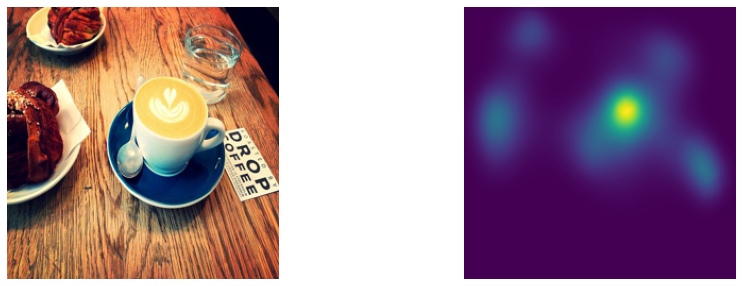

In [37]:

# Create a figure and display the image

plt.subplots(1,2, figsize=(15,5))
plt.subplot(1,2,1)
print(img_tensor.squeeze(0).shape)
plt.imshow(img_tensor.cpu().squeeze(0).permute(1,2,0).detach().numpy())
#plt.title(f'Input Image')
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(out.cpu().permute(1,2,0).detach().numpy())
#plt.title(f'Saliency Prediction')
plt.axis("off")
# Show the figure
plt.show()
pred_sal = out

torch.Size([1, 1, 256, 256])
torch.Size([1, 256, 256])


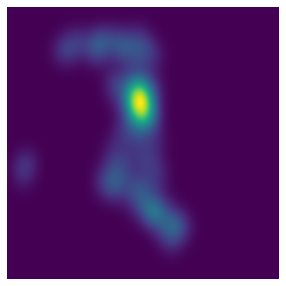

In [19]:
img = Image.open('example_images/gnochi_mirror.jpeg')
img = Image.open('/sinergia/bahar/p2p/prompt-to-prompt/salicon_example_train_gt/COCO_train2014_000000006590.png')
img_w, img_h = (256,256)
img_tensor = resize_img(img, img_w, img_h).unsqueeze(0).to(DEVICE)
print(img_tensor.shape)


plt.subplots(1,1, figsize=(15,5))
plt.subplot(1,1,1)
print(img_tensor.squeeze(0).shape)
plt.imshow(img_tensor.cpu().squeeze(0).permute(1,2,0).detach().numpy())
#plt.title(f'Saliency Ground Truth')
plt.axis("off")
plt.show()